In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import optuna
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import matplotlib_fontja
import xgboost as xgb
os.chdir('../')

c:\Users\takumi_inoue\projects\github\TakumiInoue0628\manufacturing-dx-purchase-prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


データの読み込み

In [2]:
# データの読み込み
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
sample_submit = pd.read_csv("data/sample_submit.csv", header=None)

In [3]:
# アンケートデータ分析
def analyze_survey_data(df, survey_column, target_column, figsize=(5, 3)):
    category_counts = df[survey_column].value_counts().sort_index()
    plt.figure(figsize=figsize)
    bars = plt.bar(category_counts.index, category_counts.values)
    for bar in bars:
        height = bar.get_height()
        plt.text(
            x=bar.get_x() + bar.get_width() / 2,  # X座標 (棒の中央)
            y=height,                            # Y座標 (棒の高さ)
            s=f'{height}',                       # 表示するテキスト (整数で表示)
            ha='center',                         # 水平方向の位置揃え (中央)
            va='bottom'                          # 垂直方向の位置揃え (棒の下端に合わせる)
        )
    plt.xlabel(str(survey_column)+' 選択肢')
    plt.ylabel('回答数')
    plt.xticks(category_counts.index)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    average_purchase_by_survey = train.groupby(survey_column)[target_column].mean()
    plt.figure(figsize=figsize)
    bars = plt.bar(average_purchase_by_survey.index, average_purchase_by_survey.values)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3f}', va='bottom', ha='center')
    plt.xlabel(str(survey_column)+' 選択肢')
    plt.ylabel(str(target_column)+' 割合')
    plt.xticks(average_purchase_by_survey.index) # X軸の目盛りをカテゴリ名に設定
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

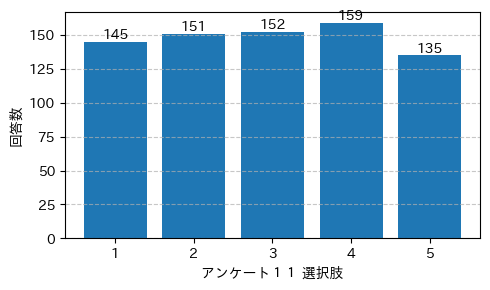

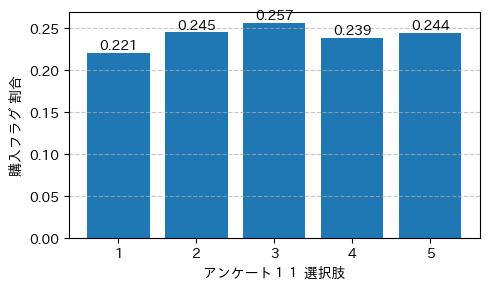

In [4]:
analyze_survey_data(train, 'アンケート１１', '購入フラグ', figsize=(5, 3))

データの前処理

In [ ]:
# 特徴量エンジニアリング関数
def feature_engineering(df):
    # 財務指標の作成 (分母が0になる可能性を考慮)
    df['自己資本比率'] = df['自己資本'] / (df['総資産'] + 1e-6)
    df['売上高営業利益率'] = df['営業利益'] / (df['売上'] + 1e-6)
    df['総資産回転率'] = df['売上'] / (df['総資産'] + 1e-6)
    df['負債比率'] = df['負債'] / (df['自己資本'] + 1e-6)
    df['従業員数_x_売上高営業利益率'] = df['従業員数'] * df['売上高営業利益率']
    return df

# カテゴリ変数のエンコード関数
def encode_categorical(df, categorical_cols):
    encoders = {}
    for col in categorical_cols:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col].astype(str))
        encoders[col] = encoder
    df = df.drop(columns=categorical_cols)
    return df, encoders

# カテゴリ変数のOne-Hotエンコード関数
def onehot_encode_categorical(df, categorical_cols, sep=', '):
    for col in categorical_cols:
        df_encode = df[col].str.get_dummies(sep=sep).add_prefix(col+'_')
        df = pd.concat([df, df_encode], axis=1)
    df = df.drop(columns=categorical_cols)
    return df

# バイナリ（２択）変数のエンコード関数
def encode_binary(df, binary_cols, true=1):
    for col in binary_cols:
        df[col] = df[col].apply(lambda x: 1 if x == true else 0)
    return df

# 組織図を特徴量化する関数
def org_chart_features(df, keyword_features = {
    'dx_it': r'DX|デジタル|IT|情報システム',
    'planning': r'経営企画|経営戦略|事業企画',
    'quality': r'品質管理|品質保証|プロセス改善|業務改革',
    'rd': r'R&D|研究開発|新技術',
    'risk': r'リスク管理|内部監査|コンプライアンス',
    'mfg': r'製造|工場|生産技術'
}):
    df = df.fillna('')
    org_df = pd.DataFrame()
    # 組織の規模（行数）
    org_df[df.name + '_line_count'] = df.apply(lambda x: len(x.split('\n')))
    # 組織単位数を（├, └, ┌の数）
    org_df[df.name + '_unit_count']= df.str.count(r'[├└┌]')
    # 特定部門の有無
    for col_name, pattern in keyword_features.items():
        org_df[df.name + "_has_" + col_name] = df.str.contains(pattern, case=False, na=False).astype(int)
    return org_df

# テキストデータの特徴量化関数（文章量）
def text_length_features(df):
    df = df.fillna('')
    length = [len(text) for text in df]
    length_df = pd.DataFrame(length, index=df.index, columns=[df.name + "_length"])
    return length_df

# テキストデータの特徴量化関数（ポジネガ出現率）
def pos_neg_ratio(df, positive_words, negative_words):
    df = df.fillna('')
    pos_neg_features = []
    for text in df:
        pos_count = sum(text.count(word) for word in positive_words)
        neg_count = sum(text.count(word) for word in negative_words)
        total_count = len(text.split())
        pos_ratio = pos_count / total_count if total_count > 0 else 0
        neg_ratio = neg_count / total_count if total_count > 0 else 0
        pos_neg_features.append([pos_ratio, neg_ratio])
    pos_neg_df = pd.DataFrame(pos_neg_features, index=df.index, columns=[df.name + "_pos_ratio", df.name + "_neg_ratio"])
    return pos_neg_df

# テキストデータの特徴量化関数（TF-IDF）
def tfidf_vectorization(df, max_features=100, ngram_range=(1, 2)):
    df = df.fillna('')
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    X_tfidf = vectorizer.fit_transform(df).toarray()
    df_idfs = pd.DataFrame(X_tfidf, index=df.index)
    df_idfs.columns = df.name + "_" + vectorizer.get_feature_names_out()
    return df_idfs

In [4]:
# Xとyの分割
target_col = '購入フラグ'
X_train_df = train.drop(columns=[target_col])
y_train_df = train[target_col]
X_test_df = test.copy()

# 学習・テストデータの結合
X_train_df.index = "train_" + X_train_df.index.astype(str)
X_test_df.index = "test_" + X_test_df.index.astype(str)
X_df = pd.concat([X_train_df, X_test_df], axis=0)

# 不要な列の削除
drop_cols = ['企業ID', '企業名']
X_df = X_df.drop(columns=drop_cols)

# 指標の組み合わせによる新規指標の作成
X_df = feature_engineering(X_df)

# カテゴリ変数を数値にエンコード
categorical_cols = ['業界', '上場種別', '特徴']
X_df = onehot_encode_categorical(X_df, categorical_cols)

# ２択（はい/いいえ）変数のエンコード
binary_cols = ['アンケート６']
X_df = encode_binary(X_df, binary_cols, true=1)

# 組織図の特徴量化
org_df = org_chart_features(X_df['組織図'])
X_df = pd.concat([X_df, org_df], axis=1)
X_df = X_df.drop(columns=['組織図'])

# 企業概要テキストデータの特徴量化（TF-IDF）
tfidf_df = tfidf_vectorization(X_df['企業概要'], max_features=100, ngram_range=(1, 2))
X_df = pd.concat([X_df, tfidf_df], axis=1)
X_df = X_df.drop(columns=['企業概要'])

# 今後のDX展望テキストデータの特徴量化（文章量, ポジネガ出現率, TF-IDF）
length_df = text_length_features(X_df['今後のDX展望'])
posneg_df = pos_neg_ratio(X_df['今後のDX展望'],
                          positive_words = [
    'ます。', 'ます', 'させ', 'し、', '社員', '員が', 'さら', '全社員', 
    'します。', '内外', '企業', 'に、', 'ード', 'らに', '加速', 'さらに', 
    'せる', 'を一', 'させる', 'します', 'できる', 'ショ', '実現', 'きる', 
    'しま', 'ョン', 'す。', '化し', 'ション', '確立'
],
                           negative_words = [
    'ません', 'せん', '規模', '必要', 'ませ', '限定', 'せん。', 'ん。', 
    'ません。', 'も、', '模な', '規模な', '慎重', 'とど', 'にとど', 
    'りませ', 'りません', 'にと', '限の', 'です', '最小', 'です。', 
    '的な', '大規模', '大規', '小規', '小規模', '最小限', '小限', 'おりませ'
],)
tfidf_df = tfidf_vectorization(X_df['今後のDX展望'], max_features=100, ngram_range=(1, 2))
X_df = pd.concat([X_df, length_df, posneg_df, tfidf_df], axis=1)
X_df = X_df.drop(columns=['今後のDX展望'])

# 学習・テストデータの再分割
X_train_df = X_df.loc[X_train_df.index].reset_index(drop=True)
X_test_df = X_df.loc[X_test_df.index].reset_index(drop=True)

In [ ]:
positive_words = [
                # 実行・推進
                '積極', '強化', '推進', '加速', '導入', '構築', '注力',
                # 拡大・投資
                '投資', '拡大', '新た', '創出',
                # 改善・高度化
                '最適化', '効率化', '自動化', '活用', '高度化',
                # 意欲・目標
                '図る', '目指す']
negative_words = [
                # 慎重・停滞
                '慎重', '限定', '停滞', '見直',
                # 課題・懸念
                '課題', '懸念', '困難', '不足', '負担', 'コスト', '難し',
                # 未確定
                '検討', '未定', '具体的ではない' ]

モデルの作成

In [ ]:
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import optuna
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from typing import Dict, Any, Callable

# --- 添削・改善した最適化関数 ---
def optimize_model(
    X_train: pd.DataFrame,
    y_train: pd.Series,
    model_name: str,
    params_base: Dict[str, Any],
    define_params_func: Callable[[optuna.trial.Trial], Dict[str, Any]],
    n_folds: int = 5,
    n_trials: int = 50,
    early_stopping_rounds: int = 50,
    thresholds: np.ndarray = np.arange(0.1, 0.5, 0.01),
    random_state: int = 42
) -> Dict[str, Any]:
    """
    指定されたモデルのハイパーパラメータをOptunaで最適化する汎用関数。

    Args:
        X_train (pd.DataFrame): 学習データの特徴量
        y_train (pd.Series): 学習データの目的変数
        model_name (str): モデル名 ('lightgbm', 'xgboost', 'catboost'のいずれか)
        params_base (Dict[str, Any]): 全ての試行で固定する基本パラメータ
        define_params_func (Callable): Optunaのtrialオブジェクトを引数とし、
                                     探索するパラメータ範囲を定義して辞書を返す関数
        n_folds (int): 交差検証の分割数
        n_trials (int): Optunaの試行回数
        early_stopping_rounds (int):早期終了のラウンド数
        thresholds (np.ndarray): F1スコアを計算するための閾値の範囲
        random_state (int): 乱数シード

    Returns:
        Dict[str, Any]: 最適化結果を含む辞書
                        {'best_params': dict, 'best_score': float, 'study': optuna.study.Study}
    """
    print(f"--- Optimizing {model_name} ---")

    folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    def objective(trial: optuna.trial.Trial) -> float:
        # trialごとに探索するパラメータを動的に生成する
        if model_name == "xgboost":
            params_base['early_stopping_rounds'] = early_stopping_rounds
        params_opt = define_params_func(trial)
        params = params_base | params_opt

        oof_preds = np.zeros(X_train.shape[0])

        for _, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
            X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
            X_valid_fold, y_valid_fold = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

            if model_name == "lightgbm":
                model = lgb.LGBMClassifier(**params)
                model.fit(X_train_fold, y_train_fold,
                            eval_set=[(X_valid_fold, y_valid_fold)],
                            callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=False)])
            elif model_name == "xgboost":
                model = xgb.XGBClassifier(**params)
                model.fit(X_train_fold, y_train_fold,
                            eval_set=[(X_valid_fold, y_valid_fold)],
                            verbose=False)
            elif model_name == "catboost":
                model = CatBoostClassifier(**params)
                model.fit(X_train_fold, y_train_fold,
                            eval_set=[(X_valid_fold, y_valid_fold)],
                            use_best_model=True,
                            early_stopping_rounds=early_stopping_rounds,
                            verbose=False)
            else:
                raise ValueError(f"Unsupported model_name: {model_name}")

            oof_preds[valid_idx] = model.predict_proba(X_valid_fold)[:, 1]

        # 各foldでF1スコアを計算し、平均を返す
        f1_scores_per_threshold = []
        for t in thresholds:
            fold_f1_scores = []
            for _, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
                y_valid_fold = y_train.iloc[valid_idx]
                y_pred_fold = (oof_preds[valid_idx] > t).astype(int)
                fold_f1_scores.append(f1_score(y_valid_fold, y_pred_fold))
            f1_scores_per_threshold.append(np.mean(fold_f1_scores))
        best_f1_index = np.argmax(f1_scores_per_threshold)
        best_f1_score = f1_scores_per_threshold[best_f1_index]
        best_threshold = thresholds[best_f1_index]
        
        # OptunaのtrialにOOF予測値とベスト閾値を保存
        # (JSONシリアライズ可能な形式に変換)
        trial.set_user_attr("oof_preds", oof_preds.tolist())
        trial.set_user_attr("best_threshold", best_threshold)
        
        return best_f1_score # 最大のF1スコアを返す

    # Optunaによる最適化実行
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print("\n--- Optimization Finished ---")
    print(f"Best trial for {model_name}:")
    best_trial = study.best_trial
    print(f"  Value (Best F1 Score): {best_trial.value:.5f}")
    print("  Best Params:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    # ベストトライアルのOOF予測値と閾値を取得
    try:
        # user_attrsから値を取得
        oof_preds_best = np.array(best_trial.user_attrs['oof_preds'])
        best_threshold = best_trial.user_attrs['best_threshold']
        
        # 最適な閾値で予測値を0/1に変換
        y_pred_best = (oof_preds_best > best_threshold).astype(int)
        
        # 混合行列を計算
        cm = confusion_matrix(y_train, y_pred_best)
        
        # 混合行列を整形して表示
        print(f"\n--- Confusion Matrix (Best Trial at Threshold: {best_threshold:.4f}) ---")
        print("--------------------------|Predicted Label              |")
        print("--------------------------|-----------------------------|")
        print("--------------------------| Negative (0) | Positive (1) |")
        print("-----------|--------------|--------------|--------------|")
        # cm[0, 0] = TN, cm[0, 1] = FP
        print(f"True Label | Negative (0) | {cm[0, 0]:<12} | {cm[0, 1]:<12} | (TN, FP)")
        print("           |              |--------------|--------------|")
        # cm[1, 0] = FN, cm[1, 1] = TP
        print(f"           | Positive (1) | {cm[1, 0]:<12} | {cm[1, 1]:<12} | (FN, TP)")
        print("-----------|--------------|--------------|--------------|")

    except KeyError:
        print("\n--- Confusion Matrix ---")
        print("Could not retrieve 'oof_preds' or 'best_threshold' from user_attrs.")
    except Exception as e:
        print(f"\nError displaying confusion matrix: {e}")

    # 最適パラメータと結果を返す
    best_params = params_base | best_trial.params

    # ベストパラメータでモデルを全データで再学習し、特徴量重要度を表示
    print("\n--- Feature Importance (Best Model) ---")
    final_params = best_params.copy()
    if model_name == 'xgboost' and 'early_stopping_rounds' in final_params:
        final_params.pop('early_stopping_rounds') # fit時にeval_setがないため削除
    if model_name == "lightgbm":
        model_final = lgb.LGBMClassifier(**final_params)
        model_final.fit(X_train, y_train)
    elif model_name == "xgboost":
        model_final = xgb.XGBClassifier(**final_params)
        model_final.fit(X_train, y_train)
    elif model_name == "catboost":
        model_final = CatBoostClassifier(**final_params)
        model_final.fit(X_train, y_train, verbose=0)
    # 特徴量重要度をDataFrameに格納
    df_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model_final.feature_importances_
    })
    # 重要度の高い順にソートして表示
    df_importance = df_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    print(df_importance.head(20))
    
    return {
        'best_params': best_params,
        'best_score': best_trial.value,
        'study': study,
        'feature_importance': df_importance
    }


パラメータ最適化

In [6]:
# 基本パラメータ
lgbm_params_base = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'n_estimators': 1000,
    'is_unbalance': True,
    'random_state': 42,
    'n_jobs': -1,
    'verbose': -1
    }

# 探索するパラメータを定義する「関数」
def define_lgbm_params(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 80),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

# LightGBMモデルの最適化実行
lgbm_results = optimize_model(
    X_train_df,
    y_train_df,
    model_name="lightgbm",
    params_base=lgbm_params_base,
    define_params_func=define_lgbm_params,
    n_trials=50
)

[I 2025-10-26 22:57:10,925] A new study created in memory with name: no-name-6815d291-2dd0-426f-acad-0839e7037961


--- Optimizing lightgbm ---


[I 2025-10-26 22:57:12,592] Trial 0 finished with value: 0.6649350649350649 and parameters: {'learning_rate': 0.011583846092560279, 'num_leaves': 50, 'max_depth': 8, 'min_child_samples': 84, 'subsample': 0.7434607649850717, 'colsample_bytree': 0.8218920975508692, 'reg_alpha': 0.6802183586800953, 'reg_lambda': 0.007242176997071856}. Best is trial 0 with value: 0.6649350649350649.
[I 2025-10-26 22:57:14,549] Trial 1 finished with value: 0.6824644549763034 and parameters: {'learning_rate': 0.01875094297806755, 'num_leaves': 68, 'max_depth': 12, 'min_child_samples': 59, 'subsample': 0.9129371799429812, 'colsample_bytree': 0.6261523074245937, 'reg_alpha': 0.0011162768049345888, 'reg_lambda': 0.0004919612856846672}. Best is trial 1 with value: 0.6824644549763034.
[I 2025-10-26 22:57:16,625] Trial 2 finished with value: 0.7032967032967034 and parameters: {'learning_rate': 0.03244419402659135, 'num_leaves': 42, 'max_depth': 7, 'min_child_samples': 24, 'subsample': 0.9595918319149055, 'colsampl


--- Optimization Finished ---
Best trial for lightgbm:
  Value (Best F1 Score): 0.72043
  Best Params:
    learning_rate: 0.022460810053124065
    num_leaves: 27
    max_depth: 10
    min_child_samples: 29
    subsample: 0.8452563953322908
    colsample_bytree: 0.7141247084446641
    reg_alpha: 0.0036195831168459596
    reg_lambda: 0.1808482204904416

--- Confusion Matrix (Best Trial at Threshold: 0.3900) ---

                    Predicted Label
                   -------------------
                   | Negative (0) | Positive (1) |
-------------------|--------------|--------------|
True Label Negative (0) | 504          | 59           | (TN, FP)
True Label Positive (1) | 45           | 134          | (FN, TP)
-------------------|--------------|--------------|

--- Feature Importance (Best Model) ---
               Feature  Importance
0             売上高営業利益率        1041
1    今後のDX展望_neg_ratio         964
2    今後のDX展望_pos_ratio         957
3               アンケート７         722
4      従業員数

In [7]:
# 基本パラメータ
xgb_params_base = {
    'objective': 'binary:logistic', 
    'eval_metric': 'logloss',       
    'n_estimators': 1000,
    'scale_pos_weight': (y_train_df == 0).sum() / (y_train_df == 1).sum(), # 'is_unbalance' の代わり
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': 0,                 # 'verbose': -1 -> 'verbosity': 0
    'booster': 'gbtree'             # デフォルトだが明記
    }

# 探索するパラメータを定義する「関数」
def define_xgb_params(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

# XGBoostモデルの最適化実行
xgb_results = optimize_model(
    X_train_df,
    y_train_df,
    model_name="xgboost",
    params_base=xgb_params_base,
    define_params_func=define_xgb_params,
    n_trials=50
)

[I 2025-10-26 23:01:31,997] A new study created in memory with name: no-name-f3e25c15-5c2e-4b5a-b1ed-77fec8f9801e


--- Optimizing xgboost ---


[I 2025-10-26 23:02:00,663] Trial 0 finished with value: 0.6247086247086248 and parameters: {'learning_rate': 0.01753483047917104, 'max_depth': 3, 'min_child_weight': 55, 'subsample': 0.9298643734813785, 'colsample_bytree': 0.8241073423733882, 'reg_alpha': 1.1803298927634394e-06, 'reg_lambda': 0.2127268729974489}. Best is trial 0 with value: 0.6247086247086248.
[I 2025-10-26 23:02:31,056] Trial 1 finished with value: 0.6291079812206573 and parameters: {'learning_rate': 0.015185063314652908, 'max_depth': 3, 'min_child_weight': 39, 'subsample': 0.7434763457606245, 'colsample_bytree': 0.8552261604169866, 'reg_alpha': 4.074354017852715, 'reg_lambda': 6.586242755234279e-07}. Best is trial 1 with value: 0.6291079812206573.
[I 2025-10-26 23:02:48,154] Trial 2 finished with value: 0.6682926829268293 and parameters: {'learning_rate': 0.03286277615168729, 'max_depth': 12, 'min_child_weight': 23, 'subsample': 0.7087412828256798, 'colsample_bytree': 0.7757444287124187, 'reg_alpha': 1.9406573130605


--- Optimization Finished ---
Best trial for xgboost:
  Value (Best F1 Score): 0.71892
  Best Params:
    learning_rate: 0.022849152835177317
    max_depth: 7
    min_child_weight: 5
    subsample: 0.7251176489995864
    colsample_bytree: 0.9695792783145438
    reg_alpha: 0.03440299961571071
    reg_lambda: 1.1164620337046621e-08

--- Confusion Matrix (Best Trial at Threshold: 0.4200) ---

                    Predicted Label
                   -------------------
                   | Negative (0) | Positive (1) |
-------------------|--------------|--------------|
True Label Negative (0) | 505          | 58           | (TN, FP)
True Label Positive (1) | 46           | 133          | (FN, TP)
-------------------|--------------|--------------|

--- Feature Importance (Best Model) ---
              Feature  Importance
0       今後のDX展望_人材面では    0.040041
1        今後のDX展望_当社では    0.026618
2   今後のDX展望_neg_ratio    0.026011
3             上場種別_ST    0.024734
4      今後のDX展望_ai iot    0.022364
5  

In [9]:
# 基本パラメータ
cat_params_base = {
    'objective': 'Logloss', # CatBoostでは'Logloss'を指定
        'iterations': 1000,
        'scale_pos_weight': (y_train_df == 0).sum() / (y_train_df == 1).sum(), # 不均衡データへの対処
        'random_seed': 42,
        'verbose': 0, # 学習ログを非表示
        'early_stopping_rounds': 50 # 早期停止
    }

# 探索するパラメータを定義する「関数」
def define_cat_params(trial):
    return {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0, log=True), # L2正則化
    }

# CatBoostモデルの最適化実行
cat_results = optimize_model(
    X_train_df,
    y_train_df,
    model_name="catboost",
    params_base=cat_params_base,
    define_params_func=define_cat_params,
    n_trials=50
)

[I 2025-10-26 23:18:49,486] A new study created in memory with name: no-name-03daf6cc-1d2b-4a64-bb74-cae7d464e549


--- Optimizing catboost ---


[I 2025-10-26 23:18:56,556] Trial 0 finished with value: 0.6932668329177057 and parameters: {'learning_rate': 0.011905342974748349, 'depth': 5, 'min_data_in_leaf': 75, 'subsample': 0.7562247092383919, 'l2_leaf_reg': 3.8840462094096894e-08}. Best is trial 0 with value: 0.6932668329177057.
[I 2025-10-26 23:19:01,424] Trial 1 finished with value: 0.7039106145251397 and parameters: {'learning_rate': 0.04696389072014669, 'depth': 5, 'min_data_in_leaf': 74, 'subsample': 0.674173346962668, 'l2_leaf_reg': 0.7702537708812123}. Best is trial 1 with value: 0.7039106145251397.
[I 2025-10-26 23:19:20,623] Trial 2 finished with value: 0.6201923076923077 and parameters: {'learning_rate': 0.02556759859690252, 'depth': 9, 'min_data_in_leaf': 47, 'subsample': 0.8364793865974184, 'l2_leaf_reg': 0.19597794164947188}. Best is trial 1 with value: 0.7039106145251397.
[I 2025-10-26 23:19:25,167] Trial 3 finished with value: 0.579520697167756 and parameters: {'learning_rate': 0.05456370804089968, 'depth': 7, '


--- Optimization Finished ---
Best trial for catboost:
  Value (Best F1 Score): 0.72043
  Best Params:
    learning_rate: 0.011442078869923055
    depth: 4
    min_data_in_leaf: 87
    subsample: 0.9993864352190336
    l2_leaf_reg: 0.45932972315304443

--- Confusion Matrix (Best Trial at Threshold: 0.4700) ---
---------------------------|Predicted Label              |
---------------------------|-----------------------------|
---------------------------| Negative (0) | Positive (1) |
------------|--------------|--------------|--------------|
True Label | Negative (0) | 504          | 59           | (TN, FP)
            |              |--------------|--------------|
           | Positive (1) | 45           | 134          | (FN, TP)
------------|--------------|--------------|--------------|

--- Feature Importance (Best Model) ---
               Feature  Importance
0    今後のDX展望_neg_ratio   13.632078
1    今後のDX展望_pos_ratio    7.837627
2             売上高営業利益率    4.974707
3                長

In [10]:

# 最適化済みパラメータの設定
lgb_best_params = lgbm_results['best_params']
xgb_best_params = xgb_results['best_params']
cat_best_params = cat_results['best_params']

# アンサンブルモデルの学習と予測 ---
# K-Foldの設定
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
early_stopping_rounds = 50

# OOF (Out-of-Fold) 予測値を格納する配列
n_trains = X_train_df.shape[0]
oof_preds_lgb = np.zeros(n_trains)
oof_preds_xgb = np.zeros(n_trains)
oof_preds_cat = np.zeros(n_trains)

# テストデータに対する予測値を格納する配列
# 各Foldで学習したモデルの予測値の平均を取る
n_tests = X_test_df.shape[0]
test_preds_lgb = np.zeros(n_tests)
test_preds_xgb = np.zeros(n_tests)
test_preds_cat = np.zeros(n_tests)


print("--- Start Ensemble Training ---")
for fold, (train_idx, valid_idx) in enumerate(folds.split(X_train_df, y_train_df)):
    print(f"Fold {fold+1}/{folds.n_splits} started...")
    X_train_fold, y_train_fold = X_train_df.iloc[train_idx], y_train_df.iloc[train_idx]
    X_valid_fold, y_valid_fold = X_train_df.iloc[valid_idx], y_train_df.iloc[valid_idx]
    # --- LightGBM ---
    lgb_model = lgb.LGBMClassifier(**lgb_best_params)
    lgb_model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_valid_fold, y_valid_fold)],
                  callbacks=[lgb.early_stopping(early_stopping_rounds, verbose=False)])
    oof_preds_lgb[valid_idx] = lgb_model.predict_proba(X_valid_fold)[:, 1]
    test_preds_lgb += lgb_model.predict_proba(X_test_df)[:, 1] / folds.n_splits
    # --- XGBoost ---
    # XGBoost v2.0.0以降ではearly_stopping_roundsはfitの引数ではなくなりました
    # コンストラクタで設定します
    xgb_best_params['early_stopping_rounds'] = early_stopping_rounds
    xgb_model = xgb.XGBClassifier(**xgb_best_params)
    xgb_model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_valid_fold, y_valid_fold)],
                  verbose=False)
    oof_preds_xgb[valid_idx] = xgb_model.predict_proba(X_valid_fold)[:, 1]
    test_preds_xgb += xgb_model.predict_proba(X_test_df)[:, 1] / folds.n_splits
    # --- CatBoost ---
    cat_model = CatBoostClassifier(**cat_best_params)
    cat_model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_valid_fold, y_valid_fold)],
                  use_best_model=True,
                  early_stopping_rounds=early_stopping_rounds)
    oof_preds_cat[valid_idx] = cat_model.predict_proba(X_valid_fold)[:, 1]
    test_preds_cat += cat_model.predict_proba(X_test_df)[:, 1] / folds.n_splits
print("--- Ensemble Training Finished ---")


# アンサンブル予測と評価
# 各モデルのOOF予測値を平均して、アンサンブルのOOF予測値とする
oof_preds_ensemble = (oof_preds_lgb + oof_preds_xgb + oof_preds_cat) / 3
# F1スコアを最大化する最適な閾値を探す
thresholds = np.arange(0.1, 0.5, 0.01)
f1_scores = [f1_score(y_train_df, (oof_preds_ensemble > t).astype(int)) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = np.max(f1_scores)
print("\n--- Evaluation with OOF Predictions ---")
print(f"Best F1 score: {best_f1_score:.5f}")
print(f"Best threshold: {best_threshold:.2f}")
# 各モデル単体の最適な閾値とF1スコアを計算
f1_scores_lgb = [f1_score(y_train_df, (oof_preds_lgb > t).astype(int)) for t in thresholds]
best_threshold_lgb = thresholds[np.argmax(f1_scores_lgb)]
best_f1_lgb = np.max(f1_scores_lgb)
f1_scores_xgb = [f1_score(y_train_df, (oof_preds_xgb > t).astype(int)) for t in thresholds]
best_threshold_xgb = thresholds[np.argmax(f1_scores_xgb)]
best_f1_xgb = np.max(f1_scores_xgb)
f1_scores_cat = [f1_score(y_train_df, (oof_preds_cat > t).astype(int)) for t in thresholds]
best_threshold_cat = thresholds[np.argmax(f1_scores_cat)]
best_f1_cat = np.max(f1_scores_cat)
print(f"\nIndividual Best F1 Scores (for reference):")
print(f"  LightGBM: {best_f1_lgb:.5f} (Threshold: {best_threshold_lgb:.2f})")
print(f"  XGBoost:  {best_f1_xgb:.5f} (Threshold: {best_threshold_xgb:.2f})")
print(f"  CatBoost: {best_f1_cat:.5f} (Threshold: {best_threshold_cat:.2f})")

# 最終的なテストデータ予測
# テストデータに対する予測も平均化
test_preds_ensemble = (test_preds_lgb + test_preds_xgb + test_preds_cat) / 3
# 最適な閾値で0/1に変換
final_predictions = (test_preds_ensemble > best_threshold).astype(int)
# 提出用ファイルの作成
from datetime import datetime
now = datetime.now()
timestamp = now.strftime("%m%d%H%M")
submit_df_ensemble = sample_submit.copy()
submit_df_ensemble[1] = final_predictions
submit_df_ensemble.to_csv('submission_'+timestamp+'.csv', index=False, header=False)
print(f"Ensemble submission file saved.")

# 単体モデルの提出ファイル生成（アンサンブルを上回った場合）
# LightGBM
if best_f1_lgb > best_f1_score:
    print("\n--- LightGBM performed better than ensemble. Generating submission file... ---")
    final_predictions_lgb = (test_preds_lgb > best_threshold_lgb).astype(int)
    submit_df_lgb = sample_submit.copy()
    submit_df_lgb[1] = final_predictions_lgb
    submit_df_lgb.to_csv('submission_lgb_'+timestamp+'.csv', index=False, header=False)
    print(f"LightGBM submission file saved.")
# XGBoost
if best_f1_xgb > best_f1_score:
    print("\n--- XGBoost performed better than ensemble. Generating submission file... ---")
    final_predictions_xgb = (test_preds_xgb > best_threshold_xgb).astype(int)
    submit_df_xgb = sample_submit.copy()
    submit_df_xgb[1] = final_predictions_xgb
    submit_df_xgb.to_csv('submission_xgb_'+timestamp+'.csv', index=False, header=False)
    print(f"XGBoost submission file saved.")
# CatBoost
if best_f1_cat > best_f1_score:
    print("\n--- CatBoost performed better than ensemble. Generating submission file... ---")
    final_predictions_cat = (test_preds_cat > best_threshold_cat).astype(int)
    submit_df_cat = sample_submit.copy()
    submit_df_cat[1] = final_predictions_cat
    submit_df_cat.to_csv('submission_cat_'+timestamp+'.csv', index=False, header=False)
    print(f"CatBoost submission file saved.")

--- Start Ensemble Training ---
Fold 1/5 started...
Fold 2/5 started...
Fold 3/5 started...
Fold 4/5 started...
Fold 5/5 started...
--- Ensemble Training Finished ---

--- Evaluation with OOF Predictions ---
Best F1 score: 0.71282
Best threshold: 0.38

Individual Best F1 Scores (for reference):
  LightGBM: 0.72043 (Threshold: 0.39)
  XGBoost:  0.71892 (Threshold: 0.42)
  CatBoost: 0.72043 (Threshold: 0.47)
Ensemble submission file saved.

--- LightGBM performed better than ensemble. Generating submission file... ---
LightGBM submission file saved.

--- XGBoost performed better than ensemble. Generating submission file... ---
XGBoost submission file saved.

--- CatBoost performed better than ensemble. Generating submission file... ---
CatBoost submission file saved.
